# Call Graphs 2

This notebook demonstrates the use of the [GraphViz software](http://www.graphviz.org) and the [graphviz Python package](http://graphviz.readthedocs.org/en/latest/) to create call graphs.

This is an alternate journey to that in the [Call Graphs](./Call Graphs.ipynb) notebook.
This version ended up being more advanced than I intended, so I started over, with [Call Graphs](./Call Graphs.ipynb).

Setup:

    sudo apt-get install graphviz
    sudo pip install graphviz

## 1. Graphing `n-choose-k`

We'll start with a basic implementation of `nchoosek`; add caching (memoization); and then instrument it to create a call graph.

In [1]:
# The basic recursive `n-choose-k` implementation. This doesn't make a graph.

def nchoosek(n, k):
    if k == 0:
        return 1
    if n == k:
        return 1
    return nchoosek(n - 1, k - 1) + nchoosek(n - 1, k)

print '5 choose 2 =', nchoosek(5, 2)
print '4 choose 3 =', nchoosek(4, 3)

5 choose 2 = 10
4 choose 3 = 4


### Adding Memoization

Add a cache. This doesn't make a graph either.

In [2]:
cache = {}

def nchoosek(n, k):
    if (n, k) in cache:
        return cache[n, k]
    if k == 0:
        return 1
    if n == k:
        return 1
    r = nchoosek(n - 1, k - 1) + nchoosek(n - 1, k)
    cache[n, k] = r
    return r

print '5 choose 2 =', nchoosek(5, 2)
print '4 choose 3 =', nchoosek(4, 3)

5 choose 2 = 10
4 choose 3 = 4


### Adding Graphing

The next version uses the [graphviz module](http://graphviz.readthedocs.org/en/latest/) to create a graph and save it to a file.

In [3]:
from graphviz import Digraph

graph = Digraph(format='png')
cache = {}

def nchoosek(n, k):
    if (n, k) in cache:
        return cache[n, k]
    if k == 0:
        return 1
    if n == k:
        return 1
    graph.edge(str((n, k)), str((n - 1, k - 1)))
    graph.edge(str((n, k)), str((n - 1, k)))
    r = nchoosek(n - 1, k - 1) + nchoosek(n - 1, k)
    cache[n, k] = r
    return r

print '5 choose 2 =', nchoosek(5, 2)
print '4 choose 3 =', nchoosek(4, 3)
image_file = graph.render(filename="images/nchoosek.gv")

5 choose 2 = 10
4 choose 3 = 4


At this point the `./images` subdirectory contains (at last) these two files:

* `images/nchoosek.gv` is a textual representation of the graph. The calls to `graph.edge` collect information into `graph`, and the call to `graph.render` creates this file.

* `images/nchoosek.gv.png` is an image file. After `graph.render` saves `nchoosek.gv`, it runs the command `dot images/nchoosek.gv -Tpng -o images/nchoosek.gv.png` to create the graph image file from the graph text file. `dot` is a command from the [GraphViz](http://www.graphviz.org) software.

In [4]:
!ls images/nchoosek*

images/nchoosek-1.gv.png images/nchoosek-2.gv.png images/nchoosek.gv
images/nchoosek-2.gv     images/nchoosek-3.gv.png images/nchoosek.gv.png


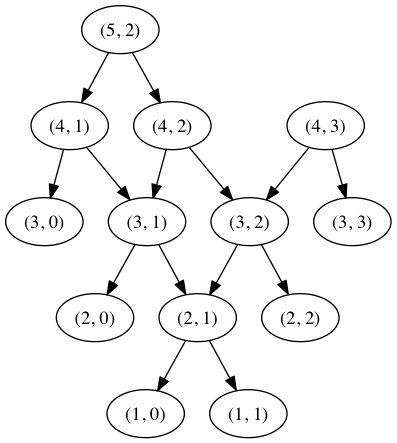

In [5]:
# Here's some magic to display an image file inside a notebook.
from IPython.display import Image
Image(filename=image_file)

## 2. Generalizing the graph instrumentation

We *could* apply the same transformation to the Levenshtein distance function, to create a call graph for *that* function.

That's a useful exercise, but in this notebook we'll tack differently. We'll take the code that was *inside* the `nchoosek`, and move it outside, into a function that we *wrap around* `nchoosek`.

We'll do this by replacing `nchoosek` with the wrapped function. `memoize`, below, is a function that takes a function as its argument, and returns a function that looks for a value inside a cache. If it can't find a cached value, it calls the original function.

In [6]:
# This doesn't create a graph.

def memoize(fn):
    cache = {}
    
    def memoized(a, b):
        key = (a, b)
        if key in cache:
            n = cache[key]
        else:
            n = fn(a, b)
            cache[key] = n
        return n
    return memoized

def nchoosek(n, k):
    if k == 0:
        return 1
    if n == k:
        return 1
    return nchoosek(n - 1, k - 1) + nchoosek(n - 1, k)

nchoosek = memoize(nchoosek)

print '5 choose 2 =', nchoosek(5, 2)
print '4 choose 3 =', nchoosek(4, 3)

5 choose 2 = 10
4 choose 3 = 4


### Adding the graph

This takes care of memoizing `nchoosek`.
Let's extend that to collect the call graph while it's memoizing.
The new function, `memoize_with_graph` returns two values: the memoized function, and the graph.

We'll develop this in two stages.
First, collect just the nodes (the function calls), without recording how they relate.

5 choose 2 = 10
4 choose 3 = 4


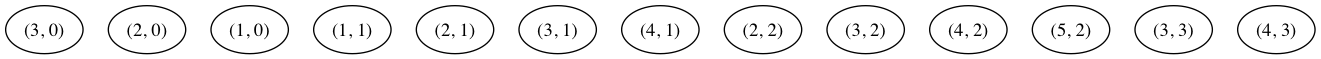

In [7]:
from graphviz import Digraph

def memoize_with_graph(fn):
    graph = Digraph(format='png', strict=True)  # strict=True combines duplicate edges
    cache = {}

    def memoized(a, b):
        key = (a, b)
        call_name = str(key)
        if key in cache:
            n = cache[key]
        else:
            n = fn(a, b)
            cache[key] = n
            graph.node(call_name)
        return n
    
    return memoized, graph

def nchoosek(n, k):
    if k == 0:
        return 1
    if n == k:
        return 1
    return nchoosek(n - 1, k - 1) + nchoosek(n - 1, k)

nchoosek, graph = memoize_with_graph(nchoosek)

print '5 choose 2 =', nchoosek(5, 2)
print '4 choose 3 =', nchoosek(4, 3)

image_file = graph.render(filename="images/nchoosek.gv")
from IPython.display import Image
Image(filename=image_file)

Now add a list, `callers`, to keep track of which function invocation called the current one.
This allows us to collect the edges.

5 choose 2 = 10
4 choose 3 = 4


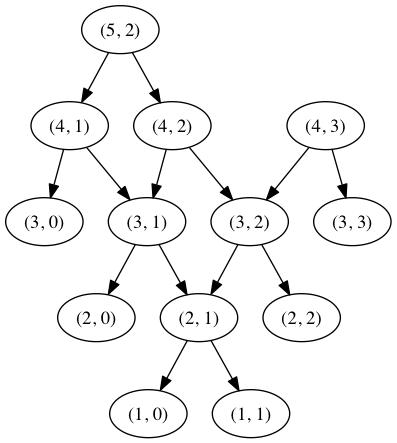

In [8]:
from graphviz import Digraph

def memoize_with_graph(fn):
    graph = Digraph(format='png', strict=True)  # strict=True combines duplicate edges
    cache = {}
    callers = []

    def memoized(a, b):
        key = (a, b)
        call_name = str(key)
        if key in cache:
            n = cache[key]
        else:
            callers.append(call_name)
            n = fn(a, b)
            callers.pop()
            cache[key] = n
            graph.node(call_name)
        if callers:
            graph.edge(callers[-1], call_name)
        return n
    
    return memoized, graph

def nchoosek(n, k):
    if k == 0:
        return 1
    if n == k:
        return 1
    return nchoosek(n - 1, k - 1) + nchoosek(n - 1, k)

nchoosek, graph = memoize_with_graph(nchoosek)

print '5 choose 2 =', nchoosek(5, 2)
print '4 choose 3 =', nchoosek(4, 3)

image_file = graph.render(filename="images/nchoosek.gv")
Image(filename=image_file)

## 3. Graphing Levenshtein and Fib

Now that we've gone to the effort to create a generic call grapher, we can graph more functions. Let's try Levenshtein.

lev("battle", "bet") = 4
lev("battle", "pedal") = 5


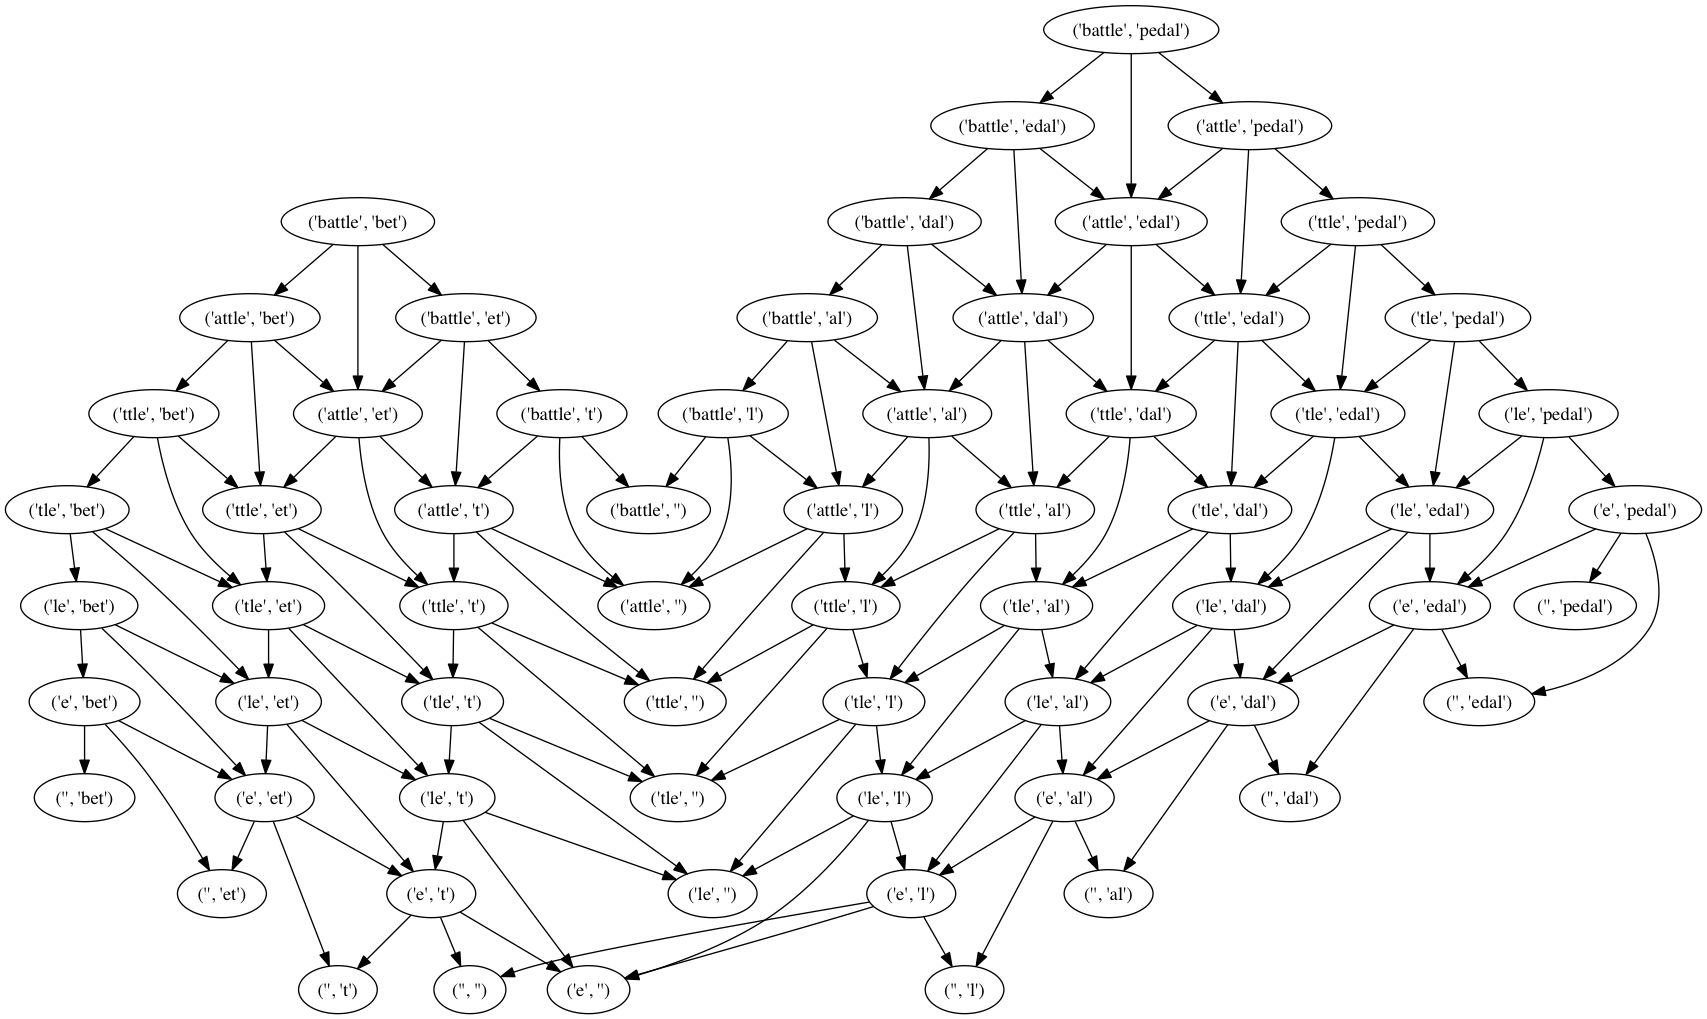

In [9]:
def lev(a, b):
    if a == "":
        return len(b)
    if b == "":
        return len(a)

    candidates = []
    if a[0] == b[0]:
        candidates.append(lev(a[1:], b[1:]))
    else:
        candidates.append(lev(a[1:], b[1:]) + 1)
    candidates.append(lev(a, b[1:]) + 1)
    candidates.append(lev(a[1:], b) + 1)
    return min(candidates)

lev, graph = memoize_with_graph(lev)
print 'lev("battle", "bet") =', lev("battle", "bet")
print 'lev("battle", "pedal") =', lev("battle", "pedal")

image_file = graph.render(filename="images/lev.gv")
Image(filename=image_file)

Fibonacci takes only one argument and our grapher only works on two-argument functions.
We'll work around that by adding a dummy argument to `fib` so that we can graph it.

fib(10) = 55


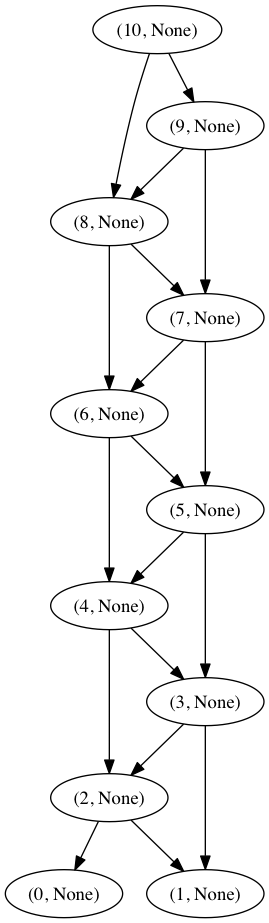

In [10]:
def fib(n, _):
    if n > 1:
        return fib(n - 2, None) + fib(n - 1, None)
    else:
        return n

fib, graph = memoize_with_graph(fib)
print 'fib(10) =', fib(10, None)

image_file = graph.render(filename="images/fib.gv")
Image(filename=image_file)

## 4. Pulling Out All the Stops

Here's a version of memoize that's more functional and easier to easier to use, at the expense of using Python features that not only haven't been covered yet, but won't be covered in this course.

Changes:

* Create *two* call graphs: one with function *calls*, and arrows pointing downwards; one with *return values*, pointing back to the caller.
* Attaches the call graphs to the function, instead of returning them in a tuple.
* Use the `fn(*args)` syntax to work with any number of arguments, so we don't have to add a dummy argument to `fib`. `fn(*args)` mean `fn(a)` or `fn(a, b)` or however many arguments there are, and collects them all into a tuple `args`.
* Don't bother saving the images to disk. Jupyter can display them directly.

In [11]:
from graphviz import Digraph

def memoize_with_graphs(fn):
    call_graph = Digraph(format='svg', strict=True)
    value_graph = Digraph(format='svg', strict=True)
    cache = {}
    callers = []

    def memoized(*args):
        key = args
        call_name = str(key)
        if key in cache:
            n = cache[key]
        else:
            callers.append(call_name)
            n = fn(*args)
            callers.pop()
            cache[key] = n
            call_graph.node(call_name, u"{}{} ⇒ {}".format(fn.__name__, key, n))
            value_graph.node(call_name, str(key))

        if callers:
            call_graph.edge(callers[-1], call_name)
            value_graph.edge(callers[-1], call_name, label=str(n), dir='back')
        else:
            call_graph.node(call_name, penwidth='3')
            value_graph.node(call_name, penwidth='3')
        return n
    
    memoized.call_graph = call_graph
    memoized.value_graph = value_graph
    return memoized

We'll also use the Python *decorator* feature:

`@memoize_with_graphs` *before* a function definition has the same effect as calling `nchoosek = memoize_with_graphs(nchoosek)` *after* the definition. In other words, these two snippets are equivalent:

Without decorators:

    def nchoosek(…):
        …
    nchoosek = memoize_with_graphs(nchoosek)

With decorators:

    @memoize_with_graphs
    def nchoosek(…):
        …

5 choose 2 = 10
4 choose 3 = 4


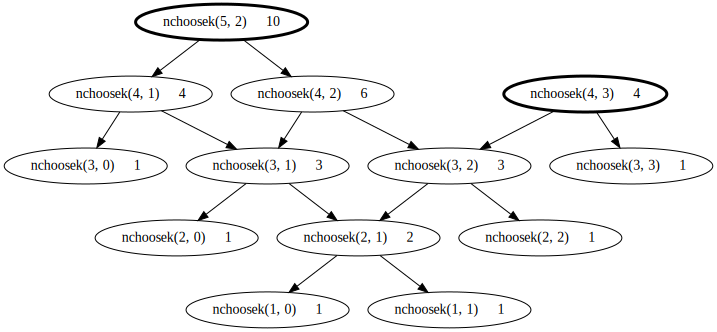

In [12]:
@memoize_with_graphs
def nchoosek(n, k):
    if k == 0:
        return 1
    if n == k:
        return 1
    return nchoosek(n - 1, k - 1) + nchoosek(n - 1, k)

print '5 choose 2 =', nchoosek(5, 2)
print '4 choose 3 =', nchoosek(4, 3)
nchoosek.call_graph

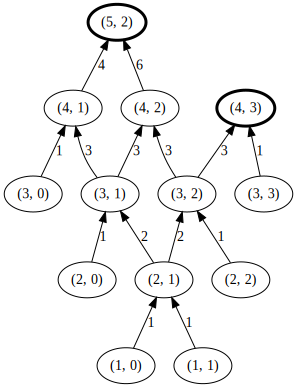

In [13]:
nchoosek.value_graph

lev("battle", "bet") = 4
lev("battle", "pedal") = 5


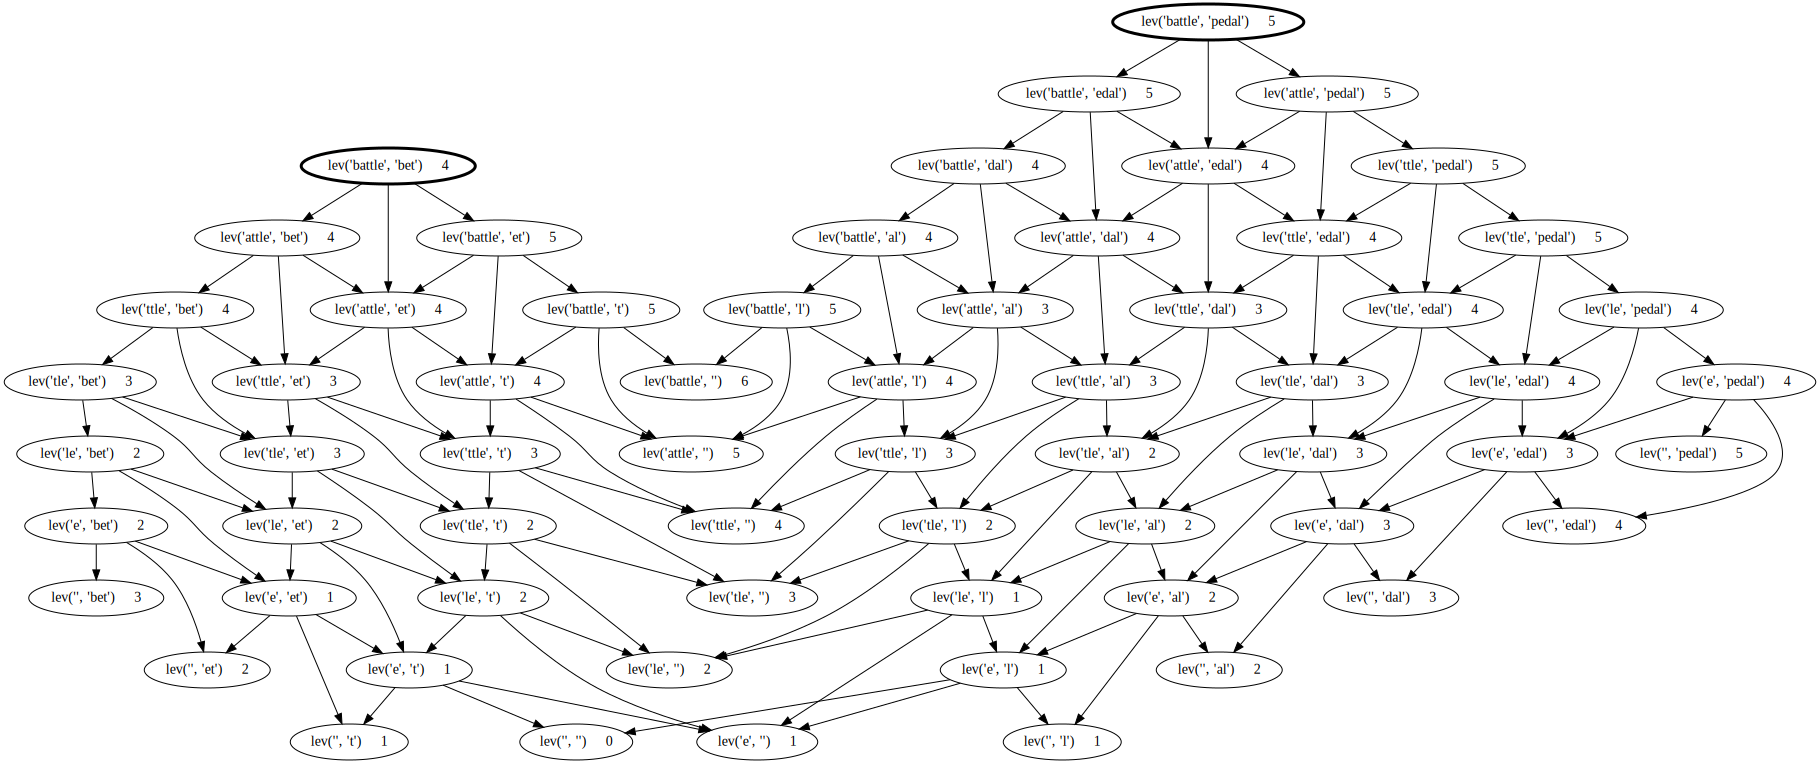

In [14]:
@memoize_with_graphs
def lev(a, b):
    if "" in (a, b):
        return len(a) + len(b)

    candidates = []
    if a[0] == b[0]:
        candidates.append(lev(a[1:], b[1:]))
    else:
        candidates.append(lev(a[1:], b[1:]) + 1)
    candidates.append(lev(a, b[1:]) + 1)
    candidates.append(lev(a[1:], b) + 1)
    return min(candidates)

print 'lev("battle", "bet") =', lev("battle", "bet")
print 'lev("battle", "pedal") =', lev("battle", "pedal")
lev.call_graph

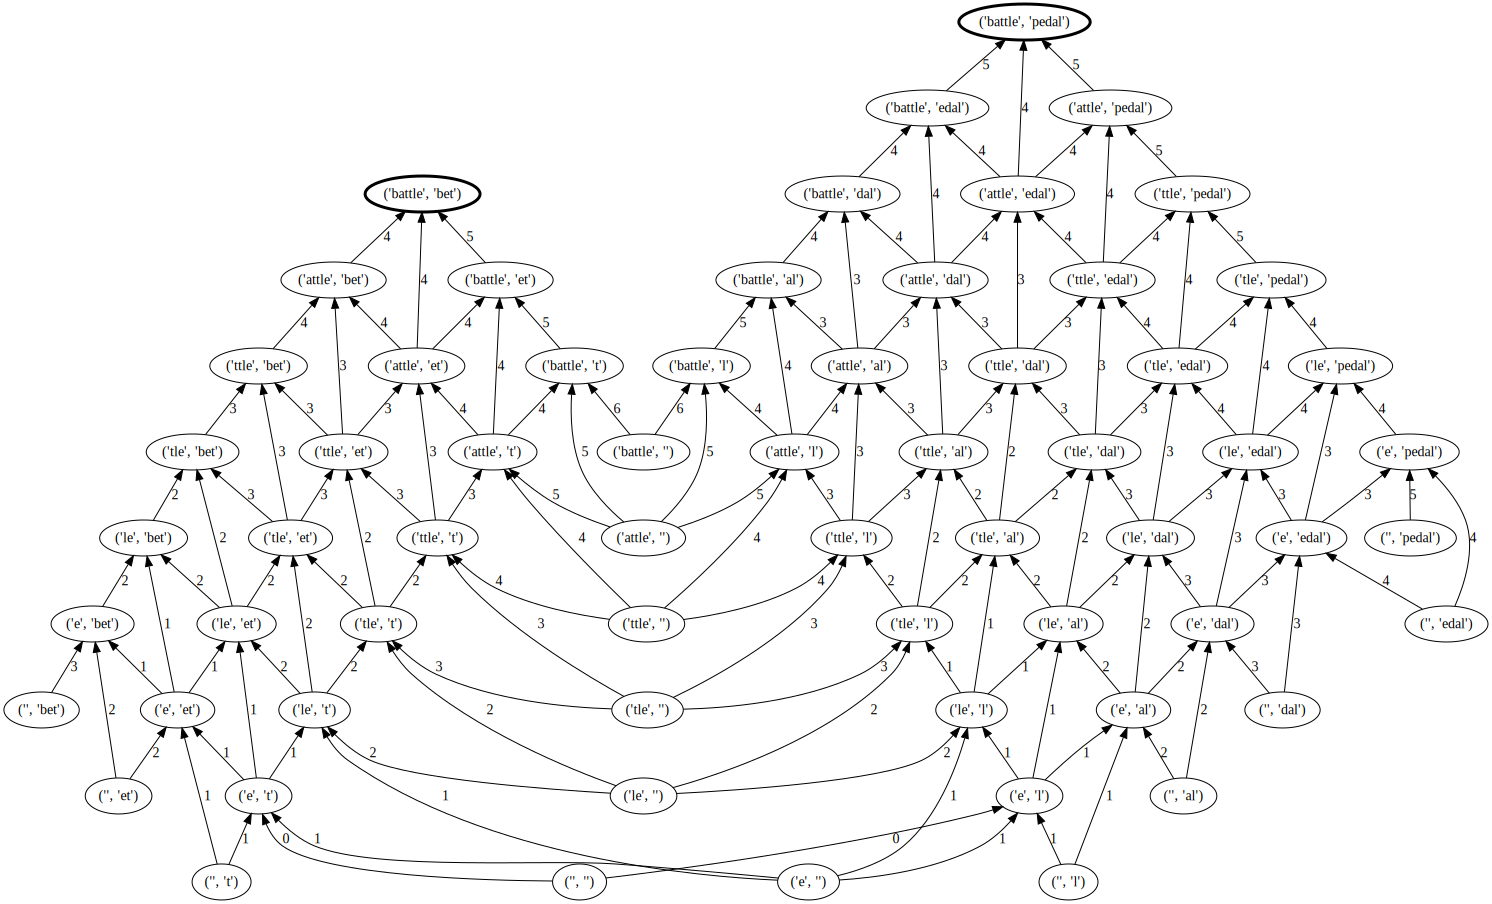

In [15]:
lev.value_graph

### `fib` revisited.

fib(10) = 55


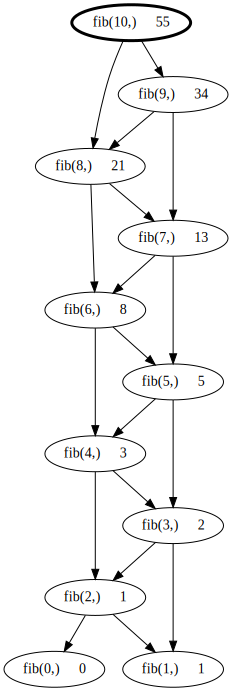

In [16]:
@memoize_with_graphs
def fib(n):
    return n if n <= 1 else fib(n - 2) + fib(n - 1)

print 'fib(10) =', fib(10)
fib.call_graph

The implementation of `memoize_with_graphs` prints an extra comma after a single-argument functions' single argument. This is because it relies on `str` to compute the string representation of an argument list, but the argument list is a tuple, and a tuple of a single element, say `1`, is represented as `(1,)`.

More work on `memoize_with_graphs` could fix this.